In [ ]:
import pandas as pd
import numpy as np
import seaborn as sb
import plotly.express as px
import matplotlib.pyplot as plt
import Library
import itertools

from matplotlib.colors import ListedColormap
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors

## <hr><center>Load the datasets cleaned by the Task 1 Notebook</center><hr>

In [ ]:
players_df = pd.read_csv('../data_cleaned/players.csv')
print(f'(players_df) Loading {players_df.shape[0]} rows from "../data_cleaned/players_df.csv"')

matches_df = pd.read_csv('../data_cleaned/matches_side.csv')
print(f'(matches_side_df) Loading {matches_df.shape[0]} rows from "../data_cleaned/matches_side_df.csv"')

players_statistics    = Library.deserialize_statistics('data/players_df.stat')
match_side_statistics = Library.deserialize_statistics('data/match_side_df.stat')


(players_df) Loading 1918 rows from "../data_cleaned/players_df.csv"
(matches_side_df) Loading 370946 rows from "../data_cleaned/matches_side_df.csv"


## <hr><center>DBSCAN</center><hr>

In [ ]:
# Consider the clustering attributes we searched and selected for the task.
clustering_attributes = ['avg_ace%', 'avg_df%', 'avg_1st%', 'avg_bpSaved%', 'win_rate', 'rank_points']

# Normalize the resulting data using StandardScaler.
scaler = StandardScaler()
numerical_attributes = Library.numerical_attributes(players_statistics)
norm_players_df = pd.DataFrame(scaler.fit_transform(players_df[numerical_attributes]), columns=numerical_attributes)
clustering_players_df = norm_players_df[clustering_attributes]


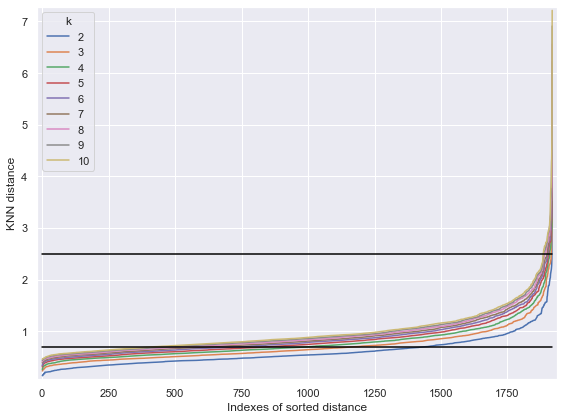

In [ ]:
k_min = 2
k_max = 10

eps_min = 0.7
eps_max = 2.5

all_dist_sorted = [None] * (k_max-k_min+1)
for k in range(k_min, k_max+1):
    nbrs = NearestNeighbors(n_neighbors=k).fit(clustering_players_df)
    distances, indices = nbrs.kneighbors(clustering_players_df)
    all_dist_sorted[k-k_min] = sorted(distances[:,-1])

sb.set_theme()
for k in range(k_min, k_max+1):
    plt.plot(list(range(1,len(all_dist_sorted[0])+1)), all_dist_sorted[k-k_min], label=k)

plt.plot([0, clustering_players_df.shape[0]], [eps_min, eps_min], color='black')
plt.plot([0, clustering_players_df.shape[0]], [eps_max, eps_max], color='black')

plt.xlabel('Indexes of sorted distance')
plt.ylabel('KNN distance')
plt.margins(0.01)
plt.gcf().set_size_inches(8, 6)
plt.legend(title="k")
Library.save('dbscan_knee.svg')

In [ ]:
# Select the searched number of k and epsilon based on the elbow method.
 
k_min = 2
k_max = 5      # k > 5 mostly results in 1 cluster.
eps_min = 1    # eps < 1 gives very low Silhouette and high Davies-Bouldin.
eps_max = 1.75 # eps > 1.75 mostly results in 1 cluster.

count = 1
data = []

# Apply a linear search in a range of 25 steps.
epsilon_search = np.linspace(eps_min, eps_max, 25)
k_search = range(k_min, k_max + 1)

# For each combination of k and epsilon, apply DBSCAN.
for i, eps in enumerate(epsilon_search):
    for j, k in enumerate(k_search):
        clustering = DBSCAN(eps=eps, min_samples=k, n_jobs=-1).fit(clustering_players_df)
        sil = silhouette_score(clustering_players_df, clustering.labels_)
        dbs = davies_bouldin_score(clustering_players_df, clustering.labels_)
        n_cluster = len(set(clustering.labels_)) - (1 if -1 in clustering.labels_ else 0)
        noise_elements = (clustering.labels_ == -1).sum() if -1 in clustering.labels_ else 0
        
        players_df['dbScanLabel'] = clustering.labels_
        min_players = players_df['dbScanLabel'].value_counts().min()

        variance = players_df['dbScanLabel'].value_counts().var(axis=0)
        count += 1
        data.append([k, str(round(eps, 2)), sil, dbs, n_cluster, min_players, noise_elements, variance])

dbscan_result_df = pd.DataFrame(data, columns=['k', 'eps', 'sil', 'dbs', 'n_cluster', 'min_players', 'noise', 'variance'])

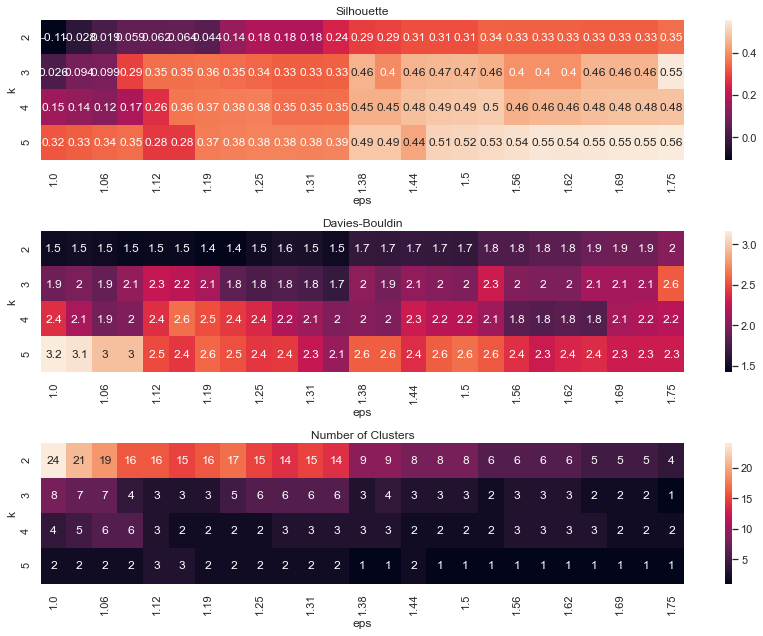

In [ ]:
# Visualize all possible combinations with useful indicators on the values of k and epsilon.
 
fig, axs = plt.subplots(nrows=3)

sb.heatmap(dbscan_result_df.pivot(index='k', columns='eps', values='sil'), annot=True, ax=axs[0])
axs[0].set_title('Silhouette', pad=5)

sb.heatmap(dbscan_result_df.pivot(index='k', columns='eps', values='dbs'), annot=True, ax=axs[1])
axs[1].set_title('Davies-Bouldin', pad=5)

# We found the number of clusters to be particularly useful, even more so
# than statistical scores to evaluate clustering quality.
sb.heatmap(dbscan_result_df.pivot(index='k', columns='eps', values='n_cluster'), annot=True, ax=axs[2])
axs[2].set_title('Number of Clusters', pad=5)

fig.tight_layout()
plt.gcf().set_size_inches(12, 9)
Library.save('dbscan_heatmap.svg')

In [ ]:
# Rerun clustering using the selected values, with the best compromise between cluster sizes and scores.

clustering = DBSCAN(eps=1.41, min_samples=3).fit(clustering_players_df)
players_df['dbScanLabel'] = clustering.labels_
players_df['dbScanLabel'].value_counts()

 0    1858
-1      49
 1       5
 2       3
 3       3
Name: dbScanLabel, dtype: int64

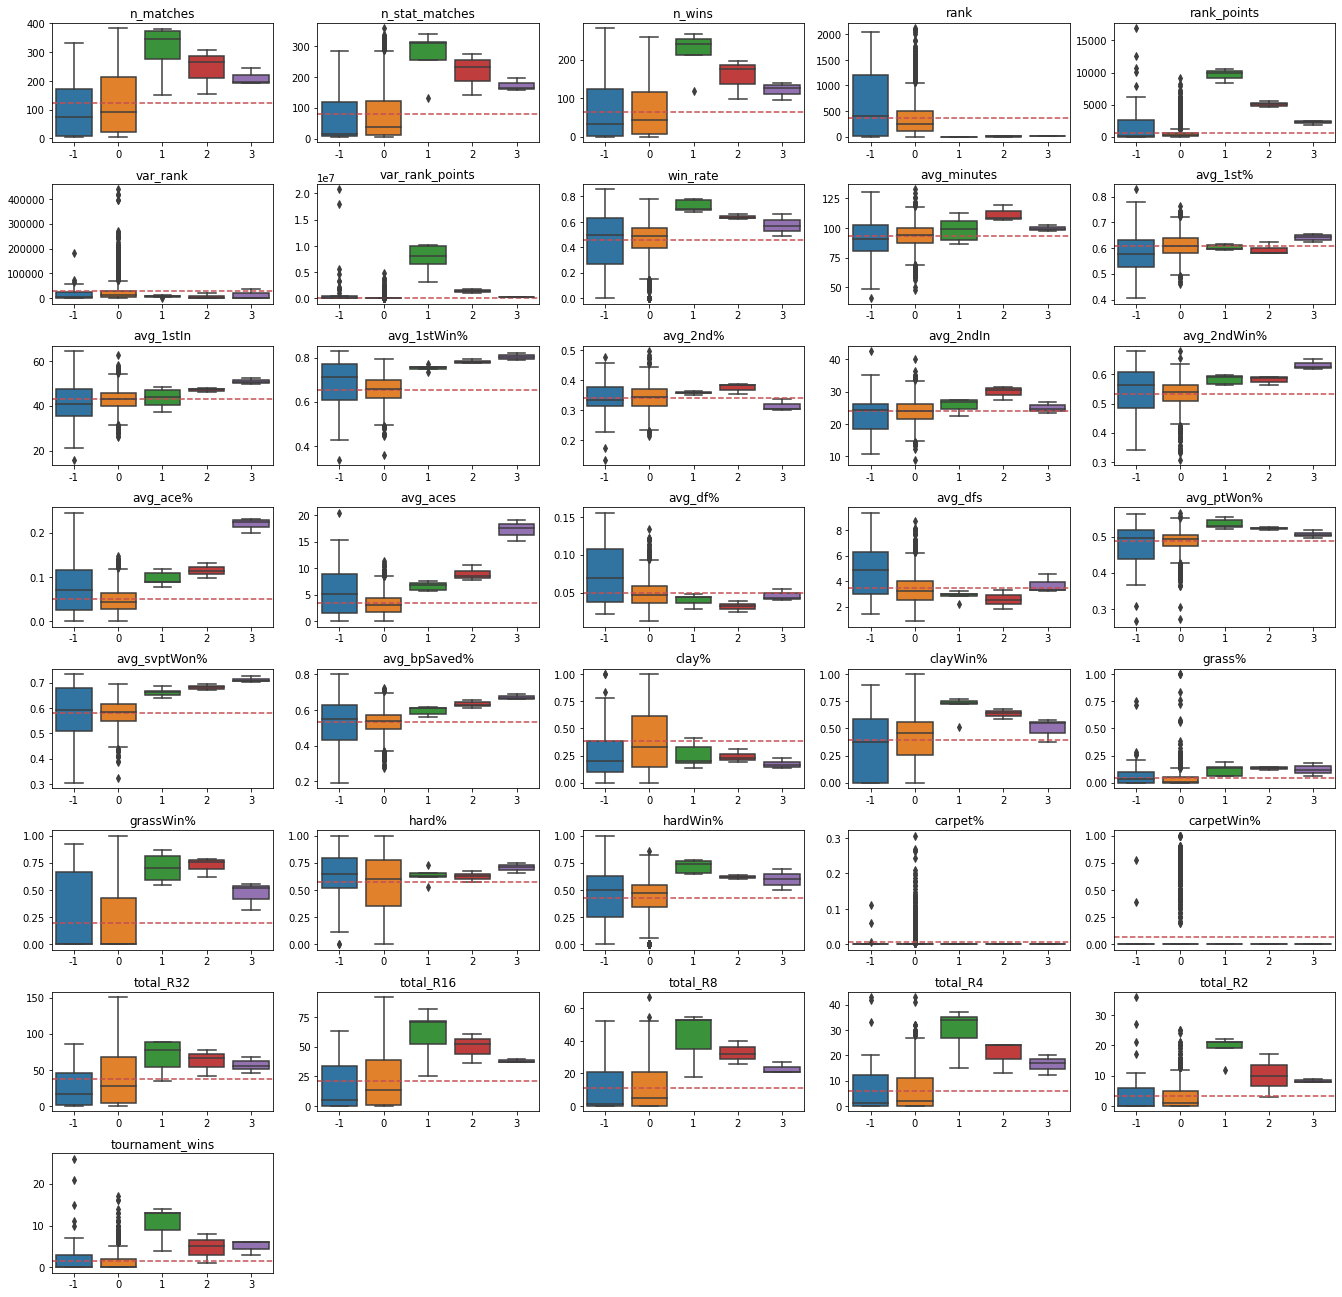

In [ ]:
# Visualize the cluster characterization.
 
sb.reset_orig()
plt.gcf().set_size_inches(20, 23)
plt.gcf().tight_layout()
plt.subplots_adjust(hspace=0.35)
Library.plot_clusters(players_statistics, players_df, 'dbScanLabel')
#Library.save('dbscan_cluster_val_box.svg')

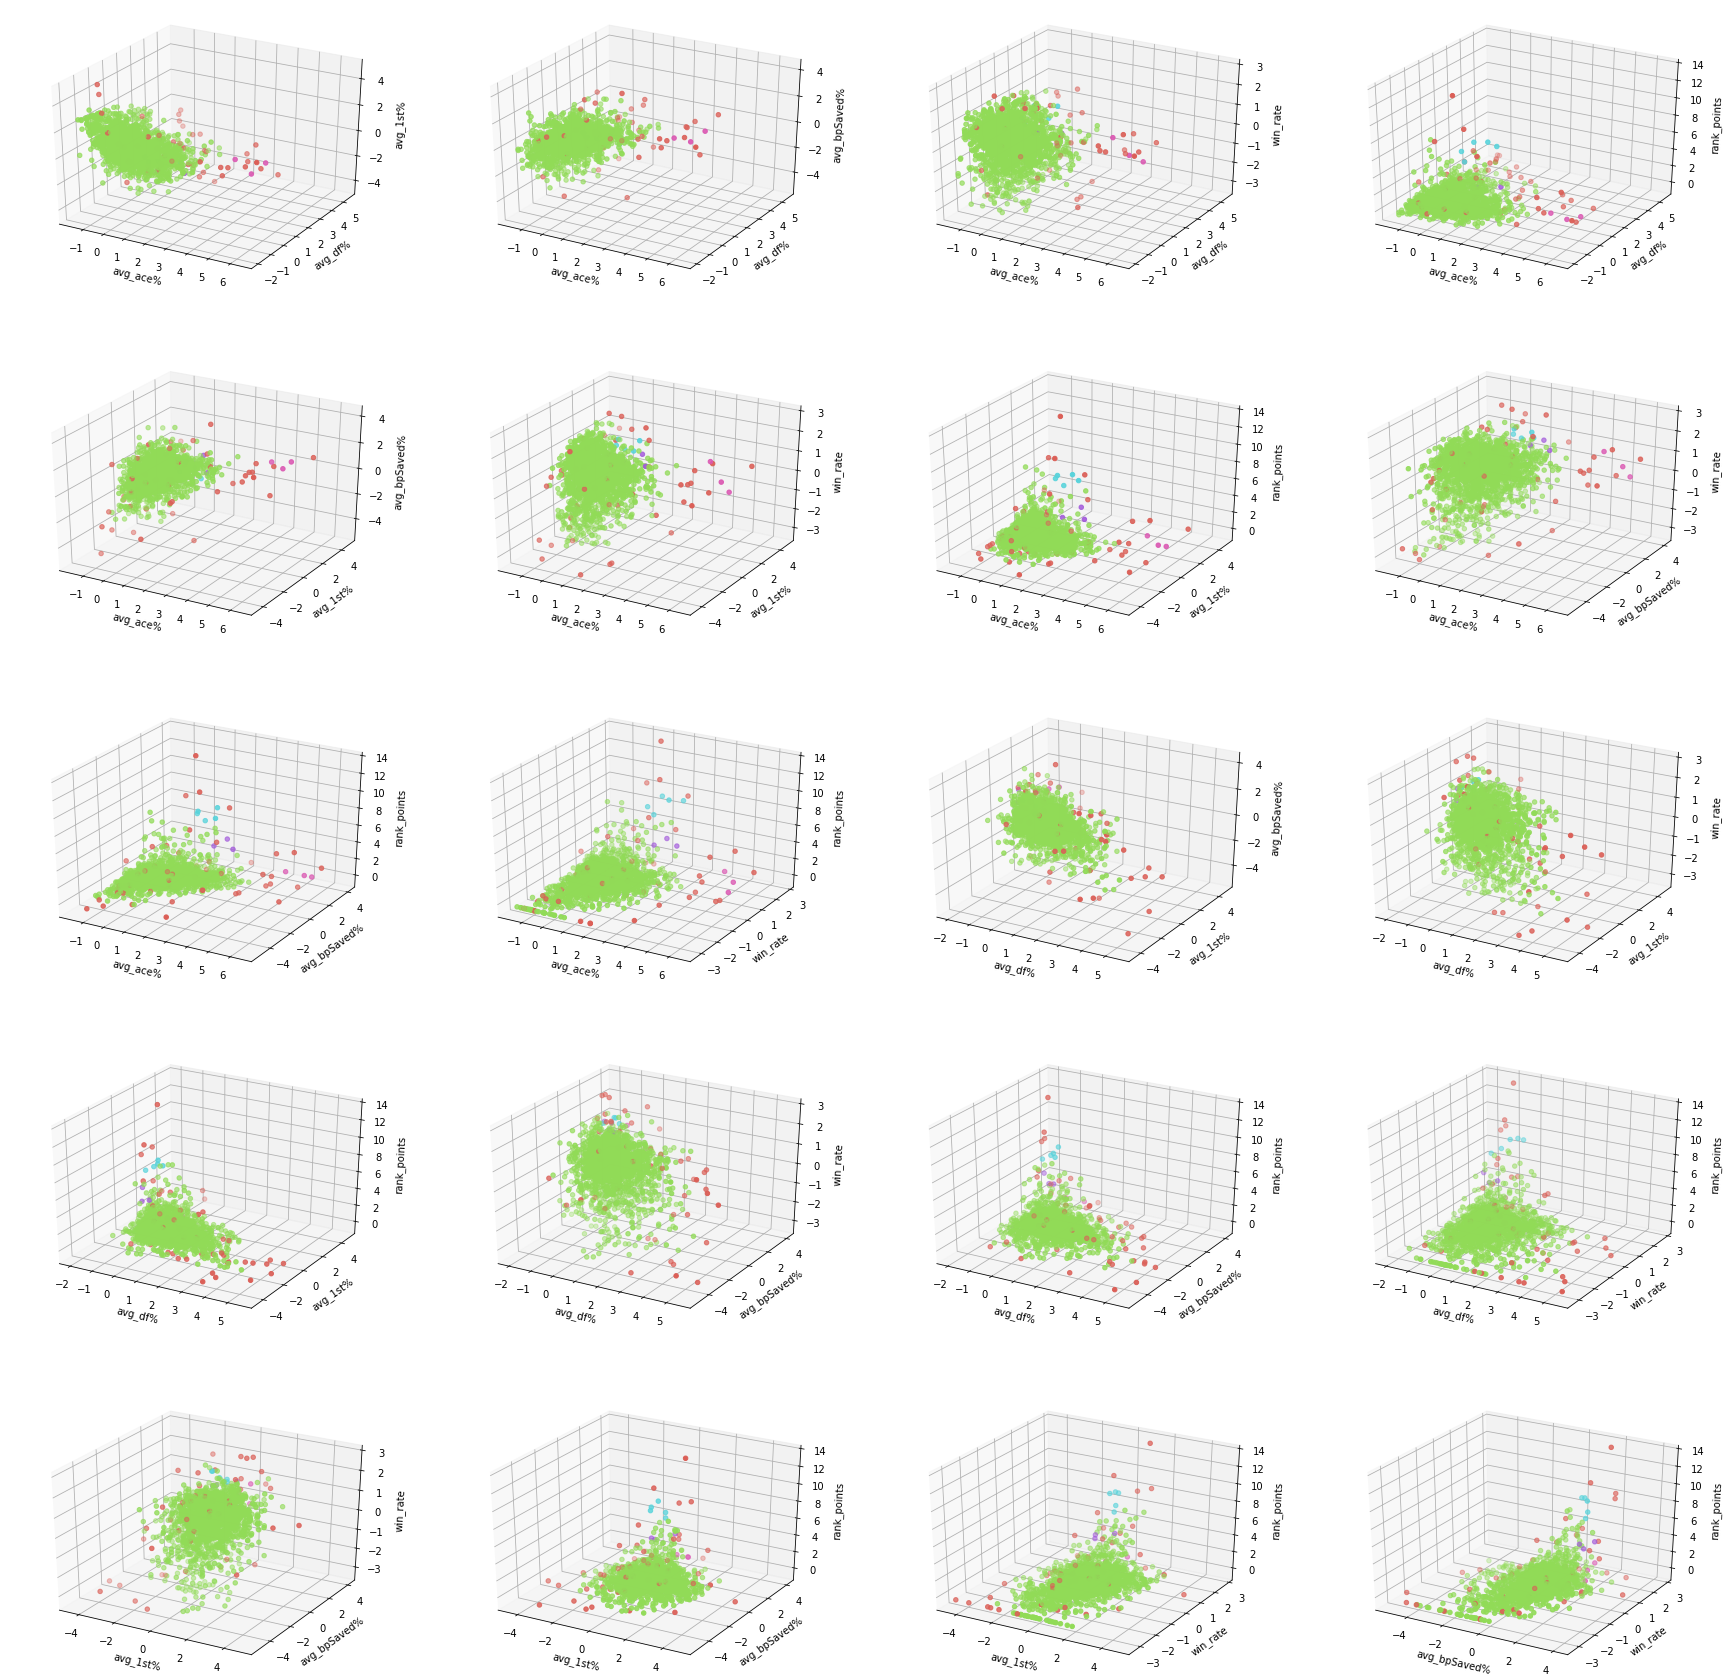

In [ ]:
# Visualize in 3D the cluster partitioning by considering 3 example attributes at a time.
# This further confirms that the high density and uniformity of the average players,
# compared with the low density  of the high ranking one, makes it difficult to further
# distinguish the two clusters and achieve a meaningful characterization based solely on density.

fig = plt.figure()

for i, attributes in enumerate(itertools.combinations(clustering_attributes, 3)):
    ax = fig.add_subplot(5, 4, i+1, projection='3d')
    ax.scatter(clustering_players_df[attributes[0]], clustering_players_df[attributes[1]], clustering_players_df[attributes[2]],
               c=players_df['dbScanLabel'], cmap=ListedColormap(sb.color_palette("hls", 8).as_hex()))
    ax.set_xlabel(attributes[0])
    ax.set_ylabel(attributes[1])
    ax.set_zlabel(attributes[2])

fig.tight_layout()

plt.gcf().set_size_inches(25, 25)
plt.show()

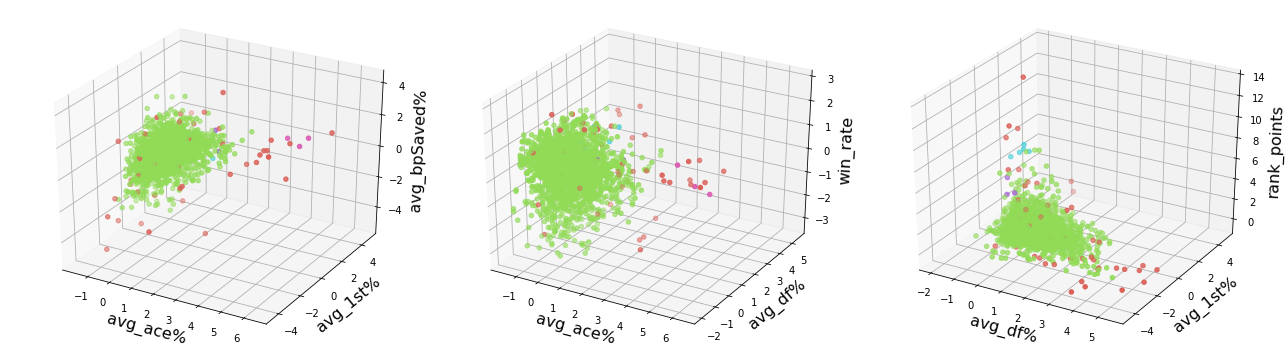

In [ ]:
# Repeat the same process as above but with a limited number of attributes.
 
attributes_to_plot = [['avg_ace%', 'avg_1st%', 'avg_bpSaved%'],
                      ['avg_ace%', 'avg_df%', 'win_rate'],
                      ['avg_df%', 'avg_1st%', 'rank_points']]

fig = plt.figure()

for i, attributes in enumerate(attributes_to_plot):
    ax = fig.add_subplot(1, 3, i+1, projection='3d')
    # Scatter plot in 3D
    ax.scatter(clustering_players_df[attributes[0]], clustering_players_df[attributes[1]], clustering_players_df[attributes[2]],
               c=players_df['dbScanLabel'], cmap=ListedColormap(sb.color_palette("hls", 8).as_hex()))
    # Attributes are in sequential order
    ax.set_xlabel(attributes[0], fontsize=16)
    ax.set_ylabel(attributes[1], fontsize=16)
    ax.set_zlabel(attributes[2], fontsize=16)

fig.tight_layout()
plt.gcf().set_size_inches(18, 5)
Library.save('dbscan_scatter3d.svg')